# Day 4 - State machines

- [Day 4](https://adventofcode.com/2018/day/4)

The guards are simple state machines.

- There are 60 points in time for each date they are on duty
- The event log record state changes
- We simply need to translate the state changes to states per minute in the midnight hour for every day

We could also save memory and only scan through each minute for a given guard and increment or decrement an 'asleep' counter as you encounter wake or sleep state changes.


In [1]:
import enum
import re
from datetime import datetime
from typing import Optional, Tuple

GuardID = int
Minute = int


class State(enum.Enum):
    off_duty = "Off Duty"
    awake = "Awake"
    asleep = "Asleep"


class Transition(enum.Enum):
    started_duty = "begins shift", State.off_duty, State.awake
    wake = "wakes up", State.asleep, State.awake
    sleep = "falls asleep", State.awake, State.asleep

    def __init__(self, pattern: str, old: State, new: State) -> None:
        self.pattern: str = pattern
        self.old: State = old
        self.new: State = new

    @classmethod
    def from_line(cls, line: str) -> Tuple[datetime, "Transition", Optional[GuardID]]:
        """Produce a (datetime, transition, guardid) tuple

        The guard information is only available for 'begins shift' entries.

        """
        match = _parse_line(line)
        if match is None:
            raise ValueError(f"Unparsable event line {line!r}")
        event = match.groupdict()
        assert (
            event["guard"]
            if event["transition"] == "begins shift"
            else event["guard"] is None
        )
        dt = datetime.strptime(event["timestamp"], "%Y-%m-%d %H:%M")
        guard = int(event["guard"]) if event["transition"] == "begins shift" else None
        return (dt, next(t for t in cls if t.pattern == event["transition"]), guard)


_parse_line = re.compile(
    r"\[(?P<timestamp>[^\]]+)\]\s+"
    r"(?:Guard\s+#(?P<guard>\d+)\s+)?"
    r"(?P<transition>{})".format("|".join([re.escape(t.pattern) for t in Transition]))
).search

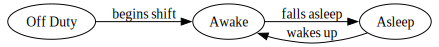

In [2]:
import graphviz
from IPython.display import display

dot = graphviz.Digraph("state_machine", graph_attr={"rankdir": "LR"}, strict=True)
for state in State:
    dot.node(state.name, state.value)
for trans in Transition:
    dot.edge(trans.old.name, trans.new.name, label=trans.pattern)
display(dot)

In [3]:
from datetime import date, timedelta
from operator import itemgetter
from typing import Dict, Iterable, Iterator, List, Sequence

_minute_header_lines: Tuple[str, str] = (
    "".join([c * 10 for c in "012345"]),
    "".join(["0123456789" * 6]),
)


class Guard:
    def __init__(self, id: GuardID) -> None:
        self.id = id
        self._events: List[Tuple[datetime, Transition]] = []
        # for each date, there are 60 states, one for each minute in the midnight hour
        self._by_date: Dict[date, List[State]] = {}
        # Cached asleep peek information, the minute and day count
        self._most_asleep: Optional[Tuple[Minute, int]] = None

    def add_events(self, *events: Tuple[datetime, Transition]) -> None:
        self._events.extend(events)
        self._by_date.clear()

    def _build_states(self) -> None:
        if self._by_date:
            return
        for dt, transition in sorted(self._events):
            assert dt.hour == 0 if transition is not Transition.started_duty else True
            d, minute = dt.date(), dt.minute
            if transition is Transition.started_duty and dt.hour:
                # move the state change to first minute of midnight
                d += timedelta(days=1)
                minute = 0
            if d not in self._by_date:
                self._by_date[d] = [State.off_duty] * 60
            states = self._by_date[d]
            assert states[minute] is transition.old
            while minute < 60 and states[minute] is transition.old:
                states[minute] = transition.new
                minute += 1
        self._most_asleep = None

    def by_minute(self) -> Iterator[Tuple[Minute, Sequence[State]]]:
        """Iterator with (date, states) entries by minute"""
        self._build_states()
        return enumerate(zip(*map(itemgetter(1), self)))

    def __iter__(self) -> Iterator[Tuple[date, Sequence[State]]]:
        """Iterate over (date, state) entries, ordered by date"""
        self._build_states()
        return iter(sorted(self._by_date.items()))

    def __repr__(self) -> str:
        return f"Guard({self.id})"

    def __str__(self) -> str:
        self._build_states()
        header = (
            f"Guard #{self.id}\n"
            f"Date   Minute\n"
            f"       {_minute_header_lines[0]}\n"
            f"       {_minute_header_lines[1]}\n"
        )
        state_map = {State.off_duty: " ", State.awake: ".", State.asleep: "#"}
        lines = "\n".join(
            [
                f"{d:%m-%d}  {''.join(map(state_map.__getitem__, states))}"
                for d, states in self
            ]
        )
        offset = " " * (self.minute_most_asleep + 7)
        return f"{header}{offset}V\n{lines}"

    @property
    def asleep(self) -> int:
        """Total time asleep on duty"""

        return sum(states.count(State.asleep) for _, states in self)

    def _calc_most_asleep(self) -> Tuple[Minute, int]:
        # Calculate and cache the minute this guard is most often asleep, together with how often
        if self._most_asleep is None:
            self._most_asleep = max(
                ((m, states.count(State.asleep)) for m, states in self.by_minute()),
                key=itemgetter(1),
            )
        return self._most_asleep

    @property
    def minute_most_asleep(self) -> Minute:
        """The minute this guard is most often asleep"""
        return self._calc_most_asleep()[0]

    @property
    def most_asleep_minute_days(self) -> int:
        """Maximum number of days this guard asleep at the same minute"""
        return self._calc_most_asleep()[1]


def schedule_from_events(events: Iterable[str]) -> Sequence[Guard]:
    events_by_date: Dict[
        date, List[Tuple[date, Transition]]
    ] = {}  # events without a guard
    guards: Dict[GuardID, Guard] = {}  # guards results
    guard_by_date: Dict[date, Guard] = {}  # date a guard is on duty, mapped to guard

    for line in events:
        dt, transition, id = Transition.from_line(line)
        d = dt.date()
        if dt.hour:
            # before midnight, only care about the next midnight part of the shift
            d += timedelta(days=1)
        if transition is Transition.started_duty:
            assert id is not None
            if id not in guards:
                guards[id] = Guard(id)
            guard_by_date[d] = guards[id]
            guards[id].add_events((dt, transition), *events_by_date.pop(d, ()))
        else:
            if d not in guard_by_date:
                events_by_date.setdefault(d, []).append((dt, transition))
            else:
                guard_by_date[d].add_events((dt, transition))

    return list(guards.values())


def print_schedule(guards: Iterable[Guard]) -> None:
    by_date: Dict[date, Tuple[GuardID, str]] = {}
    header = (
        f"Date   ID     Minute\n"
        f"              {_minute_header_lines[0]}\n"
        f"              {_minute_header_lines[1]}\n"
    )
    state_map = {State.off_duty: " ", State.awake: ".", State.asleep: "#"}
    for guard in guards:
        for d, states in guard:
            by_date[d] = (guard.id, "".join(map(state_map.__getitem__, states)))
    print(header)
    for d, (id, stateline) in sorted(by_date.items()):
        print(f"{d:%m-%d}  #{id:<4d}  {stateline}")

In [4]:
from operator import attrgetter

testdata = """\
[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up
""".splitlines()
testguards = schedule_from_events(testdata)
print_schedule(testguards)
assert testguards[0].asleep == 50, testguards[0].minute_most_asleep == 24
assert testguards[1].asleep == 30
longest_asleep = max(testguards, key=attrgetter("asleep"))
assert longest_asleep.id * longest_asleep.minute_most_asleep == 240
most_asleep_at_time = max(testguards, key=attrgetter("most_asleep_minute_days"))
assert most_asleep_at_time.id * most_asleep_at_time.minute_most_asleep == 4455

Date   ID     Minute
              000000000011111111112222222222333333333344444444445555555555
              012345678901234567890123456789012345678901234567890123456789

11-01  #10    .....####################.....#########################.....
11-02  #99    ........................................##########..........
11-03  #10         ...................#####...............................
11-04  #99      ..................................##########..............
11-05  #99       ..........................................##########.....


In [5]:
import aocd

data = aocd.get_data(day=4, year=2018)
guards = schedule_from_events(data.splitlines())
print_schedule(guards)

Date   ID     Minute
              000000000011111111112222222222333333333344444444445555555555
              012345678901234567890123456789012345678901234567890123456789

02-19  #2141  ........................##################################..
02-20  #2777   ...............####..........................#######.......
02-21  #2749  .........########################################...........
02-22  #2749  ................................................###########.
02-23  #2749   ..............................#################....#.......
02-24  #2879    ....................##########.........##############.....
02-25  #2141  ..........................................###########.......
02-26  #2879  ....###########################........##........#####......
02-27  #769   ...........##........................################.......
02-28  #191      ..........................##########################.....
03-01  #2879  ................###################.............###.........
03-

In [6]:
choice = max(guards, key=attrgetter("asleep"))
print(choice)
print("Part 1:", choice.id * choice.minute_most_asleep)

Guard #1049
Date   Minute
       000000000011111111112222222222333333333344444444445555555555
       012345678901234567890123456789012345678901234567890123456789
                                            V
03-22  ......###################################################...
04-01   .................................######################....
04-15  .........................#####.......##.....................
04-18  ..........###########..............#######################..
04-24    .............................##########...................
05-07  .................#####......................................
05-10  .................................#......##################..
05-12  ########################################################....
06-08      ......#########################################.....##..
06-10     .........#######################################.........
06-11   ........................###########################........
06-22  .....################################

## Part 2 - slicing the same data for a different metric

We already have this information, all it took was a bit of refactoring to make the data easier to sort on.


In [7]:
choice = max(guards, key=attrgetter("most_asleep_minute_days"))
print(choice)
print("Part 2:", choice.id * choice.minute_most_asleep)

Guard #2879
Date   Minute
       000000000011111111112222222222333333333344444444445555555555
       012345678901234567890123456789012345678901234567890123456789
                                                        V
02-24    ....................##########.........##############.....
02-26  ....###########################........##........#####......
03-01  ................###################.............###.........
03-04   .............................................#####.........
03-15  ...........................##########################.......
03-19     .......#################################################.
03-23  ................................................#####.......
04-02   ..........................##.................############..
04-26     ...............................................####......
05-04  .............................................#####...######.
05-16  ........##########################.....###############......
06-01  .....######..............